# Load framework

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from datetime import datetime
import os
from time import clock

/anaconda/envs/ml_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Set up matplotlib

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Load datasets

In [79]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels
X_valid = mnist.validation.images
y_valid = mnist.validation.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [97]:
ind_04_train = (np.argmax(y_train, axis=1) <= 4)
ind_04_test = (np.argmax(y_test, axis=1) <= 4)
ind_04_valid = (np.argmax(y_valid, axis=1) <= 4)
X_train_04 = X_train[ind_04_train]
y_train_04 = np.delete(y_train[ind_04_train], [5,6,7,8,9], axis=1)
X_test_04 = X_test[ind_04_test]
y_test_04 = np.delete(y_test[ind_04_test], [5,6,7,8,9], axis=1)
X_valid_04 = X_valid[ind_04_valid]
y_valid_04 = np.delete(y_valid[ind_04_valid], [5,6,7,8,9], axis=1)

#### Check data

In [98]:
print(len(mnist.train.images))
print(len(mnist.test.images))
print(len(mnist.validation.images))
print(y_train_04.shape)

55000
10000
5000
(28038, 5)


#### Load a image

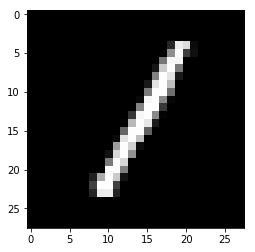

1


In [99]:
some_index = 50000
some_digit = mnist.train.images[some_index]

plt.imshow(some_digit.reshape(28, 28), cmap="gray")
plt.show()
print(np.argmax(mnist.train.labels[some_index]))

# Now build the computational graph for 0-4

# \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## First iteration

In [136]:
iter_ind=1

### define some variables

In [137]:
train_size = mnist.train.num_examples
n_epoch = 50
batch_size = 200

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 100 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

### first define some common functions

In [138]:
from functools import partial

In [139]:
def my_dnn_layer(activation=None, 
                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer()):
    return partial(tf.layers.dense, activation=activation)

In [140]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [141]:
tf.reset_default_graph()

In [142]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")

In [143]:
selu_layer = my_dnn_layer(activation=tf.nn.selu)
linear_layer = my_dnn_layer(activation=None)

with tf.name_scope("dnn"):
    hidden1 = selu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    hidden2 = selu_layer(hidden1, n_neuron["n_hidden2"], name="hidden2")
    hidden3 = selu_layer(hidden2, n_neuron["n_hidden3"], name="hidden3")
    hidden4 = selu_layer(hidden3, n_neuron["n_hidden4"], name="hidden4")
    hidden5 = selu_layer(hidden4, n_neuron["n_hidden5"], name="hidden5")
    logits = linear_layer(hidden5, n_label_04, name="logits")

In [144]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [145]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [146]:
with tf.name_scope("train"):
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [148]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, time_now, "saves")
log_dir = os.path.join(base_dir, time_now, "logs")

with tf.name_scope("savNlog"):
    saver = tf.train.Saver()
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

# with tf.name_scope("make_batch"):
    X_batch_tens, y_batch_tens = tf.train.batch(
        [mnist.train.images, mnist.train.labels], batch_size=batch_size, capacity=capacity,
        num_threads=1, allow_smaller_final_batch=True)

In [149]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [150]:
with tf.Session() as sess:
    sess.run(inits)
    file_writer.add_graph(tf.get_default_graph())
    tf.train.start_queue_runners(sess=sess)
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            sess.run(train_op, feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % 5:
            train_acc, log_train = sess.run([acc, train_acc_log], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val = sess.run([acc, validation_acc_log],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \nValidation accuracy: {:<6.4f}"
                  .format(epoch, train_acc, val_acc))
            if not epoch % 10:
                save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//10)))
                
    file_writer.close()

epoch: 5  Training accuracy: 0.9950, 
Validation accuracy: 0.9880
epoch: 10 Training accuracy: 0.9888, 
Validation accuracy: 0.9889
epoch: 15 Training accuracy: 0.9893, 
Validation accuracy: 0.9906
epoch: 20 Training accuracy: 0.9908, 
Validation accuracy: 0.9915
epoch: 25 Training accuracy: 0.9916, 
Validation accuracy: 0.9916
epoch: 30 Training accuracy: 0.9917, 
Validation accuracy: 0.9917
epoch: 35 Training accuracy: 0.9918, 
Validation accuracy: 0.9918
epoch: 40 Training accuracy: 0.9919, 
Validation accuracy: 0.9919
epoch: 45 Training accuracy: 0.9920, 
Validation accuracy: 0.9920
epoch: 50 Training accuracy: 0.9921, 
Validation accuracy: 0.9921


### Test the result on test set

In [151]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/1/20180119013331/saves/5.ckpt
Accuracy for test set is: 0.9957


# \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Second iteration

In [152]:
iter_ind = 2

<Strong>Change</Strong>
<ol>
    <li>changed neuron per layer to 150
    </li>
    <li>changed activation function to elu for comparison
    </li>
</ol>

### define some variables

In [163]:
train_size = mnist.train.num_examples
n_epoch = 50
batch_size = 200

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 150 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

### define some common functions

In [164]:
from functools import partial

def my_dnn_layer(activation=None, 
                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer()):
    return partial(tf.layers.dense, activation=activation)

In [165]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [166]:
tf.reset_default_graph()

In [167]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")

In [168]:
elu_layer = my_dnn_layer(activation=tf.nn.elu)
linear_layer = my_dnn_layer(activation=None)

with tf.name_scope("dnn"):
    hidden1 = elu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    hidden2 = elu_layer(hidden1, n_neuron["n_hidden2"], name="hidden2")
    hidden3 = elu_layer(hidden2, n_neuron["n_hidden3"], name="hidden3")
    hidden4 = elu_layer(hidden3, n_neuron["n_hidden4"], name="hidden4")
    hidden5 = elu_layer(hidden4, n_neuron["n_hidden5"], name="hidden5")
    logits = linear_layer(hidden5, n_label_04, name="logits")

In [169]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [170]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [171]:
with tf.name_scope("train"):
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [173]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, time_now, "saves")
log_dir = os.path.join(base_dir, time_now, "logs")

with tf.name_scope("savNlog"):
    saver = tf.train.Saver()
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

In [174]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [175]:
with tf.Session() as sess:
    sess.run(inits)
    file_writer.add_graph(tf.get_default_graph())
    tf.train.start_queue_runners(sess=sess)
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            sess.run(train_op, feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % 5:
            train_acc, log_train = sess.run([acc, train_acc_log], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val = sess.run([acc, validation_acc_log],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \nValidation accuracy: {:<6.4f}"
                  .format(epoch, train_acc, val_acc))
            if not epoch % 10:
                save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//10)))
                
    file_writer.close()

epoch: 5  Training accuracy: 1.0000, 
Validation accuracy: 0.9840
epoch: 10 Training accuracy: 0.9851, 
Validation accuracy: 0.9868
epoch: 15 Training accuracy: 0.9872, 
Validation accuracy: 0.9888
epoch: 20 Training accuracy: 0.9890, 
Validation accuracy: 0.9898
epoch: 25 Training accuracy: 0.9900, 
Validation accuracy: 0.9906
epoch: 30 Training accuracy: 0.9907, 
Validation accuracy: 0.9911
epoch: 35 Training accuracy: 0.9912, 
Validation accuracy: 0.9915
epoch: 40 Training accuracy: 0.9916, 
Validation accuracy: 0.9918
epoch: 45 Training accuracy: 0.9919, 
Validation accuracy: 0.9920
epoch: 50 Training accuracy: 0.9921, 
Validation accuracy: 0.9922


### Test the result on test set

In [176]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/2/20180119014100/saves/5.ckpt
Accuracy for test set is: 0.9953


# \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Third iteration

In [195]:
iter_ind = 3

<Strong>Change</Strong>
<ol>
    <li>Layer number back to 100 for faster training, same for selu
    </li>
    <li>Adding early stopping
    </li>
</ol>

### define some variables

In [196]:
train_size = mnist.train.num_examples
n_epoch = 50
batch_size = 200
max_drop = 5

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 100 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

log_freq = 5

### define some common functions

In [197]:
from functools import partial

def my_dnn_layer(activation=None, 
                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer()):
    return partial(tf.layers.dense, activation=activation)

In [198]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [199]:
tf.reset_default_graph()

In [200]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")

In [201]:
selu_layer = my_dnn_layer(activation=tf.nn.selu)
linear_layer = my_dnn_layer(activation=None)

with tf.name_scope("dnn"):
    hidden1 = selu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    hidden2 = selu_layer(hidden1, n_neuron["n_hidden2"], name="hidden2")
    hidden3 = selu_layer(hidden2, n_neuron["n_hidden3"], name="hidden3")
    hidden4 = selu_layer(hidden3, n_neuron["n_hidden4"], name="hidden4")
    hidden5 = selu_layer(hidden4, n_neuron["n_hidden5"], name="hidden5")
    logits = linear_layer(hidden5, n_label_04, name="logits")

In [202]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [203]:
with tf.name_scope("train"):
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [204]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [205]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, time_now, "saves")
log_dir = os.path.join(base_dir, time_now, "logs")

with tf.name_scope("savNlog"):
    saver = tf.train.Saver()
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

In [206]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [207]:
with tf.Session() as sess:
    sess.run(inits)
    
    file_writer.add_graph(tf.get_default_graph())
    
    max_val_loss = np.inf
    count_drop_loss = 0
    best_model_loss = None
    
    max_val_acc = 0
    count_drop_acc = 0
    best_model_acc = None
    
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            
            sess.run(train_op, feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % log_freq:
            train_acc, log_train, train_loss = sess.run([acc, train_acc_log, loss], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val, val_loss = sess.run([acc, validation_acc_log, loss],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \n              Training loss: {:<6.6f}\n\
                  Validation accuracy: {:<6.4f}\n                      Validation loss: {:<6.6f}"
                  .format(epoch, train_acc, train_loss, val_acc, val_loss))

            save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//log_freq)))
            
            if val_loss < max_val_loss:
                max_val_loss = val_loss
                best_model_loss = save_file_path
                count_drop_loss = 0
            else:
                count_drop_loss += 1


            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_acc = save_file_path
                count_drop_acc = 0
            else:
                count_drop_acc += 1
            if count_drop_acc > max_drop and count_drop_loss > max_drop:
                break
            print(count_drop_acc, count_drop_loss)
                
    file_writer.close()

epoch: 5  Training accuracy: 1.0000, 
              Training loss: 0.002594
                  Validation accuracy: 0.9880
                      Validation loss: 0.047893
0 0
epoch: 10 Training accuracy: 0.9888, 
              Training loss: 0.000118
                  Validation accuracy: 0.9898
                      Validation loss: 0.054172
0 1
epoch: 15 Training accuracy: 0.9902, 
              Training loss: 0.001589
                  Validation accuracy: 0.9911
                      Validation loss: 0.044657
0 0
epoch: 20 Training accuracy: 0.9913, 
              Training loss: 0.000295
                  Validation accuracy: 0.9912
                      Validation loss: 0.054318
0 1
epoch: 25 Training accuracy: 0.9914, 
              Training loss: 0.000024
                  Validation accuracy: 0.9910
                      Validation loss: 0.055939
1 2
epoch: 30 Training accuracy: 0.9911, 
              Training loss: 0.005227
                  Validation accuracy: 0.9907
        

### Test the result on test set

In [208]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_acc)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/3/20180119022727/saves/10.ckpt
Accuracy for test set is: 0.9940


In [209]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_loss)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/3/20180119022727/saves/7.ckpt
Accuracy for test set is: 0.9942


In [210]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/3/20180119022727/saves/10.ckpt
Accuracy for test set is: 0.9940


# \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Fourth iteration

In [216]:
iter_ind = 4

<Strong>Change</Strong>
<ol>
    <li>Adding BN
    </li>
<!--     <li>Adding early stopping
    </li> -->
</ol>

### define some variables

In [249]:
train_size = mnist.train.num_examples
n_epoch = 100
batch_size = 200
max_drop = 5

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 100 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

log_freq = 5

### define some common functions

In [250]:
from functools import partial

def my_dnn_layer(**key_args):
    return partial(tf.layers.dense, **key_args)

In [251]:
def my_batch_norm(**key_args):
    return partial(tf.layers.batch_normalization, **key_args)

In [252]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [253]:
tf.reset_default_graph()

In [254]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")
training = tf.placeholder_with_default(False, None, name="training")

In [255]:
selu_layer = my_dnn_layer(activation=tf.nn.selu)
linear_layer = my_dnn_layer(activation=None)

batch_layer = my_batch_norm(training=training)

with tf.name_scope("dnn"):
    hidden1 = selu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    bn1 = batch_layer(hidden1, name="bn1")
    hidden2 = selu_layer(bn1, n_neuron["n_hidden2"], name="hidden2")
    bn2 = batch_layer(hidden2, name="bn2")
    hidden3 = selu_layer(bn2, n_neuron["n_hidden3"], name="hidden3")
    bn3 = batch_layer(hidden3, name="bn3")
    hidden4 = selu_layer(bn3, n_neuron["n_hidden4"], name="hidden4")
    bn4 = batch_layer(hidden4, name="bn4")
    hidden5 = selu_layer(bn4, n_neuron["n_hidden5"], name="hidden5")
    bn5 = batch_layer(hidden5, name="bn5")
    logits = linear_layer(bn5, n_label_04, name="logits")

In [256]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [257]:
with tf.name_scope("train"):
    batch_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [258]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [259]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, time_now, "saves")
log_dir = os.path.join(base_dir, time_now, "logs")

with tf.name_scope("savNlog"):
    saver = tf.train.Saver(max_to_keep=20)
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

In [260]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [261]:
with tf.Session() as sess:
    sess.run(inits)
    
    file_writer.add_graph(tf.get_default_graph())
    
    max_val_loss = np.inf
    count_drop_loss = 0
    best_model_loss = None
    
    max_val_acc = 0
    count_drop_acc = 0
    best_model_acc = None
    
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            
            sess.run([train_op, batch_updates], feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % log_freq:
            train_acc, log_train, train_loss = sess.run([acc, train_acc_log, loss], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val, val_loss = sess.run([acc, validation_acc_log, loss],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \n              Training loss: {:<6.6f}\n\
                  Validation accuracy: {:<6.4f}\n                      Validation loss: {:<6.6f}"
                  .format(epoch, train_acc, train_loss, val_acc, val_loss))

            save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//log_freq)))
            
            if val_loss < max_val_loss:
                max_val_loss = val_loss
                best_model_loss = save_file_path
                count_drop_loss = 0
            else:
                count_drop_loss += 1


            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_acc = save_file_path
                count_drop_acc = 0
            else:
                count_drop_acc += 1
            if count_drop_acc > max_drop and count_drop_loss > max_drop:
                break
            print(count_drop_acc, count_drop_loss)
                
    file_writer.close()

epoch: 5  Training accuracy: 0.9950, 
              Training loss: 0.005974
                  Validation accuracy: 0.9902
                      Validation loss: 0.033956
0 0
epoch: 10 Training accuracy: 0.9909, 
              Training loss: 0.004205
                  Validation accuracy: 0.9898
                      Validation loss: 0.036859
1 1
epoch: 15 Training accuracy: 0.9902, 
              Training loss: 0.001278
                  Validation accuracy: 0.9908
                      Validation loss: 0.045906
0 2
epoch: 20 Training accuracy: 0.9910, 
              Training loss: 0.000021
                  Validation accuracy: 0.9913
                      Validation loss: 0.041380
0 3
epoch: 25 Training accuracy: 0.9915, 
              Training loss: 0.000008
                  Validation accuracy: 0.9918
                      Validation loss: 0.036323
0 4
epoch: 30 Training accuracy: 0.9919, 
              Training loss: 0.000004
                  Validation accuracy: 0.9922
        

### Test the result on test set

In [262]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_acc)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/20180119025246/saves/20.ckpt
Accuracy for test set is: 0.9946


In [264]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_loss)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from /Users/apple/AnacondaProjects/handson-ml/chapter_11_exer/temp/4/20180119025246/saves/16.ckpt
Accuracy for test set is: 0.9944


In [265]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/20180119025246/saves/20.ckpt
Accuracy for test set is: 0.9946


# \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Fifth iteration

In [216]:
iter_ind = 5

<Strong>Change</Strong>
<ol>
    <li>Parsing the structure into a sklearn func
    </li>
    <li>Changing the structure of saving file
    </li>
</ol>

### define some variables

In [249]:
train_size = mnist.train.num_examples
n_epoch = 100
batch_size = 200
max_drop = 5

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 100 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

log_freq = 5

### define some common functions

In [250]:
from functools import partial

def my_dnn_layer(**key_args):
    return partial(tf.layers.dense, **key_args)

In [251]:
def my_batch_norm(**key_args):
    return partial(tf.layers.batch_normalization, **key_args)

In [252]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [253]:
tf.reset_default_graph()

In [254]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")
training = tf.placeholder_with_default(False, None, name="training")

In [255]:
selu_layer = my_dnn_layer(activation=tf.nn.selu)
linear_layer = my_dnn_layer(activation=None)

batch_layer = my_batch_norm(training=training)

with tf.name_scope("dnn"):
    hidden1 = selu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    bn1 = batch_layer(hidden1, name="bn1")
    hidden2 = selu_layer(bn1, n_neuron["n_hidden2"], name="hidden2")
    bn2 = batch_layer(hidden2, name="bn2")
    hidden3 = selu_layer(bn2, n_neuron["n_hidden3"], name="hidden3")
    bn3 = batch_layer(hidden3, name="bn3")
    hidden4 = selu_layer(bn3, n_neuron["n_hidden4"], name="hidden4")
    bn4 = batch_layer(hidden4, name="bn4")
    hidden5 = selu_layer(bn4, n_neuron["n_hidden5"], name="hidden5")
    bn5 = batch_layer(hidden5, name="bn5")
    logits = linear_layer(bn5, n_label_04, name="logits")

In [256]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [257]:
with tf.name_scope("train"):
    batch_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [258]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [259]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, "saves", time_now)
log_dir = os.path.join(base_dir, "logs", time_now)

with tf.name_scope("savNlog"):
    saver = tf.train.Saver(max_to_keep=20)
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

In [260]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [261]:
with tf.Session() as sess:
    sess.run(inits)
    
    file_writer.add_graph(tf.get_default_graph())
    
    max_val_loss = np.inf
    count_drop_loss = 0
    best_model_loss = None
    
    max_val_acc = 0
    count_drop_acc = 0
    best_model_acc = None
    
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            
            sess.run([train_op, batch_updates], feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % log_freq:
            train_acc, log_train, train_loss = sess.run([acc, train_acc_log, loss], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val, val_loss = sess.run([acc, validation_acc_log, loss],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \n              Training loss: {:<6.6f}\n\
                  Validation accuracy: {:<6.4f}\n                      Validation loss: {:<6.6f}"
                  .format(epoch, train_acc, train_loss, val_acc, val_loss))

            save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//log_freq)))
            
            if val_loss < max_val_loss:
                max_val_loss = val_loss
                best_model_loss = save_file_path
                count_drop_loss = 0
            else:
                count_drop_loss += 1


            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_acc = save_file_path
                count_drop_acc = 0
            else:
                count_drop_acc += 1
            if count_drop_acc > max_drop and count_drop_loss > max_drop:
                break
            print(count_drop_acc, count_drop_loss)
                
    file_writer.close()

epoch: 5  Training accuracy: 0.9950, 
              Training loss: 0.005974
                  Validation accuracy: 0.9902
                      Validation loss: 0.033956
0 0
epoch: 10 Training accuracy: 0.9909, 
              Training loss: 0.004205
                  Validation accuracy: 0.9898
                      Validation loss: 0.036859
1 1
epoch: 15 Training accuracy: 0.9902, 
              Training loss: 0.001278
                  Validation accuracy: 0.9908
                      Validation loss: 0.045906
0 2
epoch: 20 Training accuracy: 0.9910, 
              Training loss: 0.000021
                  Validation accuracy: 0.9913
                      Validation loss: 0.041380
0 3
epoch: 25 Training accuracy: 0.9915, 
              Training loss: 0.000008
                  Validation accuracy: 0.9918
                      Validation loss: 0.036323
0 4
epoch: 30 Training accuracy: 0.9919, 
              Training loss: 0.000004
                  Validation accuracy: 0.9922
        

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=50, activation=tf.nn.elu, initializer=None,
                 batch_norm=None, dropout_rate=None, random_state=None):
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer= initializer
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None
        self._graph = None
        self._training = tf.placeholder_with_default(False, None, name="training")
        
    def _dnn_layout(self):
        if type(self.n_neurons) is int:
            self._n_neurons = (self.n_neurons for i in range(self.n_hidden_layers))
        elif type(self.n_neurons) is list:
            self._n_neurons = iter(self.n_neurons)
        else:
            raise InvalidNumberNeurons("The number of neurons given must be integer or list")
        with tf.name_scope("dnn"):
            for lay in range(self.n_hidden_layers):
                if self.dropout_rate:
                    inputs = 

### Test the result on test set

In [262]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_acc)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/20180119025246/saves/20.ckpt
Accuracy for test set is: 0.9946


In [264]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_loss)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from /Users/apple/AnacondaProjects/handson-ml/chapter_11_exer/temp/4/20180119025246/saves/16.ckpt
Accuracy for test set is: 0.9944


In [265]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/20180119025246/saves/20.ckpt
Accuracy for test set is: 0.9946
